In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

from pathlib import Path

# from keras.layers import Input, Dense
# from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
#os.listdir(dataset)

In [3]:

class FFNN:
    #self.dataset = Path('../input/New_sounds/Three Sounds')
    def __init__(self):
        self.dataset = Path('../input/three sounds/Three Sounds')
        self.df = pd.DataFrame()
        self.labels = []
        self.getlabels()
        self.one_hot_encode(self.df,self.labels)
        #self.inputs = Input
        #self.df['feats'] = self.df.feats_raw.apply(preprocess)
        #self.feats_extraction(dataset)
        self.get_features()
        self.apply_function()
        self.hotencoding()
        self.data_split()
        
        
            # a layer instance is callable on a tensor, and returns a tensor
#         x = Dense(64, activation='relu')(self.inputs)
#         x = Dense(64, activation='relu')(x)
#         x = Dense(64, activation='relu')(x)
#         self.predictions = Dense(self.Output_num, activation='softmax')(x)
        
        
        
        self.model = Sequential()
        self.model.add(Dense(128, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros"))
        self.model.add(Dropout(0.30))
        self.model.add(Dense(64, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros"))
        self.model.add(Dropout(0.20))
        self.model.add(Dense(32, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros"))
        self.model.add(Dropout(0.10))
        self.model.add(Dense(self.Output_num, activation='softmax'))
        self.build_model()
        #self.graphs()
        
    
    def getlabels(self):
        self.labels = [folder.name for folder in self.dataset.glob('*')]
        frame_files, frame_labels = [], []
        for folder in self.dataset.glob('*'):
            files = [path for path in folder.glob('*')]
            frame_files.extend(files)
            frame_labels.extend([folder.name] * len(files))
        frame = [frame_files, frame_labels]
        self.df['Path'] = frame_files
        self.df['Label'] = frame_labels
    
    def apply_function(self):
        self.df['feats'] = self.df.feats_raw.apply(self.pre_process)
        
    
    #######################Feature Extraction######################
    def feats_extraction(self,path):
        raw_signal, sample_rate = librosa.load(path)
        mfccs = librosa.feature.mfcc(raw_signal, sample_rate) # 20 features (default)
        chroma = librosa.feature.chroma_stft(raw_signal, sample_rate) # 12 features
        stft = np.abs(librosa.stft(raw_signal))
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate) # 7 features
        return np.concatenate([mfccs, chroma, contrast])
    
    def get_features(self):
        self.df['feats_raw'] = self.df.Path.apply(self.feats_extraction)
        
    #######################Feature Per File#########################
    def pre_process(self,feature_matrix):
        feats = [
            feature_matrix.mean(axis=1),
            feature_matrix.std(axis=1),
            feature_matrix.min(axis=1),
            feature_matrix.max(axis=1),
            np.median(feature_matrix, axis=1)
        ]
        return np.stack(feats).flatten().astype(np.float32)
        
       
    
    
    #######################Feature Per File#########################
    def one_hot_encode(self, df, labels):
        encoded_labels = [np.zeros(len(self.labels), dtype='float32') for i in range(len(self.df))]
        for idx, val in enumerate(self.df['Label']):
            encoded_labels[idx][self.labels.index(val)] = 1
        return encoded_labels
    
    def hotencoding(self):
        self.df['Target'] = self.one_hot_encode(self.df, self.labels)
        self.Output_num = len(self.df['Target'][0])
    
    
    #######################Splitting the self.dataset#########################
#     num1 = float(input("Percentage for training: "))
#     num2 = float(input("Percentage for validation: "))
    
#     num2 = num1+num2
#     num3 = 1 - num2
    def data_split(self):
        indexes = np.arange(len(self.df))
        np.random.seed(4) #to ensure values say in the same set during each run and not mix up with other parameters
        np.random.shuffle(indexes)

        val_pivot = int(0.7*len(self.df))
        test_pivot = int(0.85*len(self.df))

    #     val_pivot = int(num1*len(self.df))
    #     test_pivot = int(num2*len(self.df))

        train_indexes = indexes[0:val_pivot] # 70% of self.dataset
        val_indexes = indexes[val_pivot:test_pivot] # 15% of self.dataset
        test_intexes = indexes[test_pivot:] # 15% of self.dataset

        self.df_train = self.df.iloc[train_indexes].reset_index(drop=True)
        self.df_val = self.df.iloc[val_indexes].reset_index(drop=True)
        self.df_test = self.df.iloc[test_intexes].reset_index(drop=True)

        self.train_x, self.train_y = np.stack(self.df_train['feats']), np.stack(self.df_train['Target'])
        self.val_x, self.val_y = np.stack(self.df_val['feats']), np.stack(self.df_val['Target'])
        self.test_x, self.test_y = np.stack(self.df_test['feats']), np.stack(self.df_test['Target'])
        
        #self.inputs = Input(shape=(self.train_x.shape[1],))
    
    #######################Building the model#########################
   
    
    # This returns a tensor
    

    def build_model(self):
        # self.predictions = Dense(2, activation='softmax')(self.inputs)

        # This creates a model that includes
        # the Input layer and three Dense layers
#         model = Model(inputs=self.inputs, outputs=self.predictions)
#         model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
        
        self.model.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        #print(model.summary())

        self.results_val = self.model.fit(self.train_x, self.train_y, validation_data=(self.val_x,self.val_y), epochs=200, batch_size=64) # starts training with validating
        print(self.model.summary())
#    #######################Plotting the loss###########################
#    x_axis = np.arange(200)
#    
    def graphs(self):
        x_axis = np.arange(200)
        plt.subplot(2,1,1)
        plt.plot(x_axis, self.results_val.history['loss'], x_axis, self.results_val.history['val_loss'])
        plt.title('Training Vs Training with Validation')
        plt.gca().legend(('Loss','Validation Loss'))
        plt.ylabel('Loss')
   
   
   #######################Plotting the accuracy#######################
        x_axis = np.arange(200)
        plt.subplot(2,1,2)
        plt.plot(x_axis, self.results_val.history['acc'], x_axis, self.results_val.history['val_acc'])
        plt.gca().legend(('Accuracy','Validation Accuracy'))
        plt.ylabel('Accuracy')
   
        plt.show()
    
    def graphwindow(self):
         #Tab1 = self.TNotebook1_t1
#         ent1t1 = tk.Entry(Tab1)
#         ent1t1.pack()
        
        fig = plt.figure(figsize=(5,5), dpi=100)
        a = f.add_subplot(111)
        #a.plot(self.graphs())
        a.plot(x_axis, self.results_val.history['loss'], x_axis, self.results_val.history['val_loss'])
        a.title('Training Vs Training with Validation')
        a.gca().legend(('Loss','Validation Loss'))
        a.ylabel('Loss')

        canvas = FigureCanvasTkAgg(fig, self.main_g.TNotebook1_t2)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)
   
        #plt.plot(x_axis, results_val.history['loss'], x_axis, results_val.history['val_loss'])
#    
#    #######################Plotting the accuracy#######################
#    #x_axis = np.arange(200)
#    #plt.plot(x_axis, results_val.history['acc'], x_axis, results_val.history['val_acc'])
#    
#    #######################Evaluating the model#######################
#    test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
#    print('Test accuracy:', test_acc)
#    
#    #######################Predicting self.labels with the model#################
#    self.predictions = model.predict(test_x)
#    np.argmax(self.predictions[0])
#    
#    #######################Saving the model#################################
#    model_json = model.to_json()
#    with open("model.json", "w") as json_file:
#        json_file.write(model_json)
#    # serialize weights to Hself.df5
#    model.save_weights("model.h5")
#    print("Saved model to disk")
#    
#    
#    
#    # load json and create model
#    json_file = open('model.json', 'r')
#    loaded_model_json = json_file.read()
#    json_file.close()
#    loaded_model = model_from_json(loaded_model_json)
#    # load weights into new model
#    loaded_model.load_weights("model.h5")
#    print("Loaded model from disk")

In [4]:
#database = Path('C:\\Users\Student\Desktop\Sample sounds')
p = FFNN()
p.build_model()

/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 779 samples, validate on 167 samples
Epoch 1/200
779/779 [==============================] - 0s 446us/step - loss: 0.7609 - acc: 0.7060 - val_loss: 0.3310 - val_acc: 0.8563
Epoch 2/200
779/779 [==============================] - 0s 39us/step - loss: 0.3818 - acc: 0.8588 - val_loss: 0.1992 - val_acc: 0.9341
Epoch 3/200
779/779 [==============================] - 0s 37us/step - loss: 0.3074 - acc: 0.8858 - val_loss: 0.1116 - val_acc: 0.9641
Epoch 4/200
779/779 [==============================] - 0s 36us/step - loss: 0.2258 - acc: 0.9268 - val_loss: 0.1354 - val_acc: 0.9521
Epoch 5/200
779/779 [==============================] - 0s 36us/step - loss: 0.2157 - acc: 0.9217 - val_loss: 0.1230 - val_acc: 0.9521
Epoch 6/200
779/779 [===========================

/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Train on 779 samples, validate on 167 samples
Epoch 1/200
779/779 [==============================] - 0s 535us/step - loss: 0.7609 - acc: 0.7060 - val_loss: 0.3310 - val_acc: 0.8563
Epoch 2/200
779/779 [==============================] - 0s 38us/step - loss: 0.3818 - acc: 0.8588 - val_loss: 0.1988 - val_acc: 0.9341
Epoch 3/200
779/779 [==============================] - 0s 38us/step - loss: 0.3053 - acc: 0.8858 - val_loss: 0.1122 - val_acc: 0.9641
Epoch 4/200
779/779 [==============================] - 0s 37us/step - loss: 0.2222 - acc: 0.9243 - val_loss: 0.1192 - val_acc: 0.9641
Epoch 5/200
779/779 [==============================] - 0s 36us/step - loss: 0.2245 - acc: 0.9178 - val_loss: 0.1337 - val_acc: 0.9581
Epoch 6/200
779/779 [==============================] - 0s 36us/step - loss: 0.2187 - acc: 0.9255 - val_loss: 0.0976 - val_acc: 0.9581
Epoch 7/200
779/779 [==============================] - 0s 36us/step - loss: 0.1965 - acc: 0.9358 - val_loss: 0.0599 - val_acc: 0.9940
Epoch 8/200
779

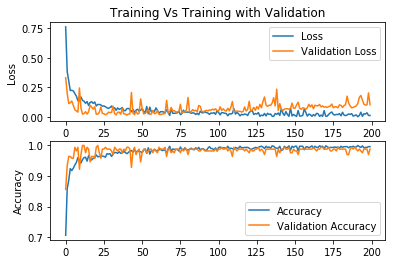

In [5]:
p1 = FFNN()
p1.graphs()